# Ranked Information Coefficient

## Install packages

In [1]:
import sys

In [2]:
#!{sys.executable} -m pip install -r requirements.txt

In [3]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [6]:
import os
import quiz_helper
from zipline.data import bundles

In [7]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),  '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [8]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [9]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [10]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [11]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## get pricing data into a dataframe

In [12]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [15]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [16]:
sector = Sector()

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [17]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

## Create smoothed momentum factor

In [18]:
from zipline.pipeline.factors import Returns
from zipline.pipeline.factors import SimpleMovingAverage


# create a pipeline called p
p = Pipeline(screen=universe)
# create a factor of one year returns, deman by sector, then rank
factor = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)


# Use this factor as input into SimpleMovingAverage, with a window length of 5
# Also rank and zscore (don't need to de-mean by sector, s)
factor_smoothed = (
    SimpleMovingAverage(inputs=[factor], window_length=5).
    rank().
    zscore()
)

# add the unsmoothed factor to the pipeline
p.add(factor, 'Momentum_Factor')
# add the smoothed factor to the pipeline too
p.add(factor_smoothed, 'Smoothed_Momentum_Factor')

## visualize the pipeline

Note that if the image is difficult to read in the notebook, right-click and view the image in a separate tab.

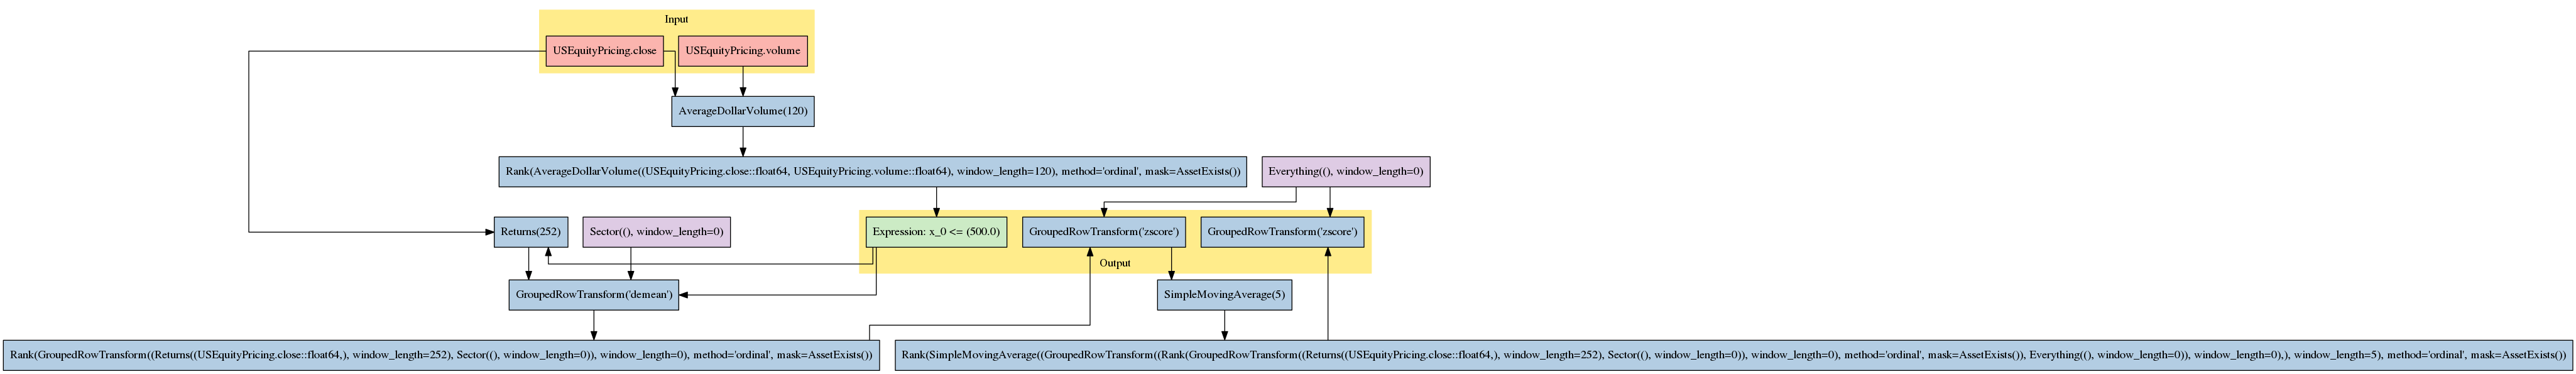

In [19]:
p.show_graph(format='png')

## run pipeline and view the factor data

In [20]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [21]:
df.head()

Momentum_Factor  \
2014-01-03 00:00:00+00:00 Equity(0 [A])            1.499391   
                          Equity(1 [AAL])          1.602797   
                          Equity(2 [AAP])          0.376694   
                          Equity(3 [AAPL])        -1.484618   
                          Equity(4 [ABBV])         0.915884   

                                            Smoothed_Momentum_Factor  
2014-01-03 00:00:00+00:00 Equity(0 [A])                     1.484618  
                          Equity(1 [AAL])                   1.573252  
                          Equity(2 [AAP])                   0.206813  
                          Equity(3 [AAPL])                 -1.477232  
                          Equity(4 [ABBV])                  0.945429

## Evaluate Factors

We'll go over some tools that we can use to evaluate alpha factors.  To do so, we'll use the [alphalens library](https://github.com/quantopian/alphalens)


## Import alphalens

In [22]:
import alphalens as al

## Get price data

Note, we already got the price data and converted it to returns, which we used to calculate a factor.  We'll retrieve the price data again, but won't convert these to returns.  This is because we'll use alphalens functions that take their input as prices and not returns.

## Define the list of assets
Just to make sure we get the prices for the stocks that have factor values, we'll get the list of assets, which may be a subset of the original universe

In [24]:
# get list of stocks in our portfolio (tickers that identify each stock)
assets = df.index.levels[1].values.tolist()
print("stock universe number of stocks {}, and number of stocks for which we have factor values {}"
     .format(len(universe_tickers),len(assets)))

stock universe number of stocks 490, and number of stocks for which we have factor values 490


In [25]:
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

In [26]:
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #notice that we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date, # notice we're using the same start and end dates for when we calculated the factor
        universe_end_date)

## Double check the dates of the pricing data
Check that they make sense compared to the factor data

In [27]:
pricing.head(2)

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2014-01-06 00:00:00+00:00,122.824,26.026,110.917,71.475,43.053,65.132,35.407,73.223,58.12,44.021,...,27.697,40.601,85.397,46.704,29.222,32.332,49.399,89.795,28.221,30.894
2014-01-07 00:00:00+00:00,124.687,25.905,112.286,70.963,43.139,65.842,35.135,74.114,58.97,44.253,...,27.697,40.690,86.606,47.426,29.464,32.426,50.093,91.587,28.306,31.010


In [28]:
pricing.tail(2)

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2016-01-04 00:00:00+00:00,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,...,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05 00:00:00+00:00,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,...,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


In [29]:
pricing.shape

(504, 490)

### Compare to the factor data for a single stock

In [30]:
stock_index_name = df.index.get_level_values(1)[3] #just pick a stock; in this case, stock number 3 is AAPL
single_stock_factor_df = df[np.in1d(df.index.get_level_values(1), [stock_index_name])]

In [31]:
single_stock_factor_df.head(2)

,,Momentum_Factor,Smoothed_Momentum_Factor
2014-01-03 00:00:00+00:00,Equity(3 [AAPL]),-1.484618,-1.477232
2014-01-06 00:00:00+00:00,Equity(3 [AAPL]),-1.469846,-1.492005


In [32]:
single_stock_factor_df.tail(2)

,,Momentum_Factor,Smoothed_Momentum_Factor
2016-01-04 00:00:00+00:00,Equity(3 [AAPL]),-0.494357,-0.530442
2016-01-05 00:00:00+00:00,Equity(3 [AAPL]),-0.306718,-0.479923


In [33]:
single_stock_factor_df.shape

(505, 2)

## Prepare data for use in alphalens

In [34]:
factor_names = df.columns
print("The factor names are {}".format(factor_names))

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    # Get clean factor and forward returns for each factor
    # Choose single period returns (daily returns)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=df[factor_name],
        prices=pricing,
        periods=[1])

The factor names are Index(['Momentum_Factor', 'Smoothed_Momentum_Factor'], dtype='object')
Formatting factor data for: Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_Factor
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Rank IC
The [factor_information_coefficient function in alphalens documentation is here.](https://quantopian.github.io/alphalens/alphalens.html#alphalens.performance.factor_information_coefficient)

Also pasted below:
```
Computes the Spearman Rank Correlation based Information Coefficient (IC) between factor values and N period forward returns for each period in the factor index.

Parameters:	
factor_data : pd.DataFrame - MultiIndex

A MultiIndex DataFrame indexed by date (level 0) and asset (level 1), containing the values for a single alpha factor, forward returns for each period, the factor quantile/bin that factor value belongs to, and (optionally) the group the asset belongs to. - See full explanation in utils.get_clean_factor_and_forward_returns

group_adjust : bool

Demean forward returns by group before computing IC.

by_group : bool

If True, compute period wise IC separately for each group.

Returns:	
ic : pd.DataFrame

Spearman Rank correlation between factor and provided forward returns.
```

## Quiz 1
Use alphalens to calculate the rank IC for each factor

## Answer 1 here:

In [35]:
ls_rank_ic = []

for i, factor_name in enumerate(factor_names):
    #TODO: use alphalens function "factor_information_coefficient" to calculate rank IC
    rank_ic = al.performance.factor_information_coefficient(factor_data[factor_name])
    rank_ic.columns = [factor_name]
    ls_rank_ic.append(rank_ic)

## View rank IC

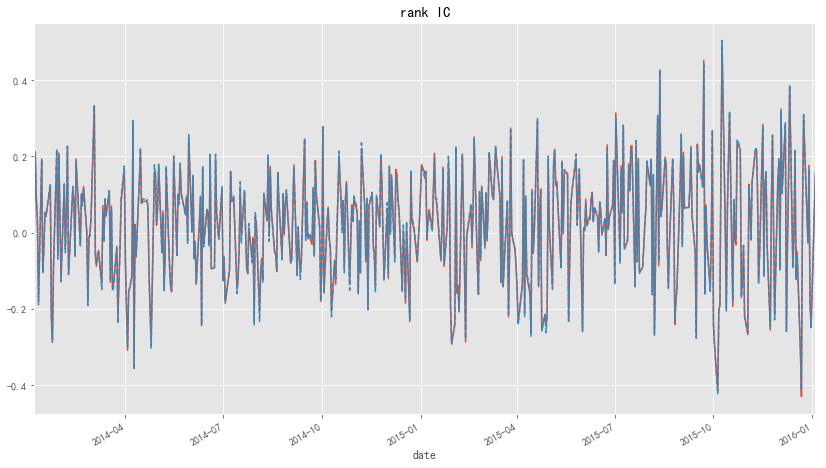

In [36]:
ls_rank_ic[0]['Momentum_Factor'].plot(title="rank IC")
ls_rank_ic[1]['Smoothed_Momentum_Factor'].plot(style='--')

## Quiz 2

What does it mean when the rank IC value is above the zero line?

## Answer 2 here:
The rank IC is above zero when the correlation between the factor values and the forward returns is positive (we ideally want to find factors for which the rank IC is more positive).

## Solution notebook
[The solution notebook is here.](rank_ic_solution.ipynb)